<a href="https://colab.research.google.com/github/Yutong-Lu/CHL5230FinalProject/blob/main/Updated_logistic%26tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import RocCurveDisplay, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('Diabetes Study File 10K Dec 14 2017.xlsx')
data.head()

,Age_at_Exam,sBP,sBP_Date,BMI,BMI_Date,LDL,LDL_Date,HDL,HDL_Date,A1c,...,leastO(A1c_Date),leastO(DM_OnsetDate),leastO(FBS_Date),LeastOfAll,A1C_BEF_DM,FBS_BEF_DM,Patient_ID,DM_Onset_Revised,DM_Onset_Revised_1YrPrior,DIABETES
0,65,126.0,2013-06-11,31.000000,2013-06-11,1.66,2013-06-14,1.11,2013-06-14,5.4,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000255903,NaT,NaT,No
1,62,135.0,2014-06-19,25.846483,2014-10-17,2.49,2014-05-28,1.37,2014-05-28,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000256456,NaT,NaT,No
2,63,133.0,2012-07-31,30.900000,2011-12-01,1.65,2012-06-01,NaN,NaT,6.1,...,NaN,NaN,NaN,NaN,NaN,NaN,1001000000000054,NaT,NaT,No
3,51,136.0,2014-01-06,56.710775,2014-01-06,2.80,2014-01-14,1.94,2014-01-14,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000259496,NaT,NaT,No
4,40,123.0,2015-06-12,33.067867,2015-06-12,2.48,2015-06-24,1.17,2015-06-24,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000262094,NaT,NaT,No


In [3]:
# Replace categorical values with numerical equivalents
data['DIABETES'].replace({'Yes' : 1, 'No' : 0}, inplace=True)
data['Sex'].replace({'Female' : 1, 'Male' : 0}, inplace=True)

# Create indicator for using hypertension meds/corticosteroid
data['Use_of_Hypertension_Medications'] = data['Hypertension_Medications'].notnull().astype('int')
data['Use_of_Corticosteroids'] = data['Corticosteroids'].notnull().astype('int')

In [4]:
# Create a subset with no date
df = data[['Age_at_Exam', 'sBP', 'BMI', 'A1c', 'TG', 'FBS', 'Total_Cholesterol', 'Depression',
     'HTN', 'OA', 'COPD', 'Use_of_Hypertension_Medications', 'Use_of_Corticosteroids', 'Sex', 'DIABETES']]

numerical_columns = ['Age_at_Exam', 'sBP', 'BMI', 'A1c', 'TG', 'FBS', 'Total_Cholesterol']

In [5]:
# define features and outcome
X = df.drop(['DIABETES'], axis=1)
y = df[['DIABETES']]

# split training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=1)

# Normalizing data
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((7000, 14), (1500, 14), (1500, 14), (7000, 1), (1500, 1), (1500, 1))

In [6]:
# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_filled_mice = imputer.fit_transform(X_train)
X_val_filled_mice = imputer.transform(X_val)
X_test_filled_mice = imputer.transform(X_test)

In [ ]:
# Check multicollinearity
# VIF dataframe
X_train_filled_mice_df = pd.DataFrame(X_train_filled_mice)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_filled_mice_df.columns


# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_filled_mice_df.values, i)
                          for i in range(len(X_train_filled_mice_df.columns))]

print(vif_data)
# All good after removing LDL and HDL

    feature       VIF
0         0  1.220620
1         1  1.122415
2         2  1.118326
3         3  2.546792
4         4  1.254313
5         5  2.612574
6         6  1.285354
7         7  1.332063
8         8  4.562149
9         9  1.569685
10       10  1.148996
11       11  4.905079
12       12  1.447272
13       13  1.999843


In [ ]:
# take a look at training X
for col in X.columns:
    print(col)

Age_at_Exam
sBP
BMI
A1c
TG
FBS
Total_Cholesterol
Depression
HTN
OA
COPD
Use_of_Hypertension_Medications
Use_of_Corticosteroids
Sex


Logistic Regression

In [ ]:
# Logistic regression feature selection

# Initialize a Logistic Regression model
model = LogisticRegression()

# Define a StratifiedKFold cross-validation
cv = StratifiedKFold(3)

# Initialize Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring='roc_auc',  # Specify the scoring metric (ROC AUC in this case)
    min_features_to_select=1,
)
rfecv.fit(X_val_filled_mice, y_val)

# Print the optimal number of selected features
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 4


In [ ]:
# which columns used and which wasn't
rfecv.support_

array([False, False, False,  True, False,  True,  True, False, False,
       False, False,  True, False, False])

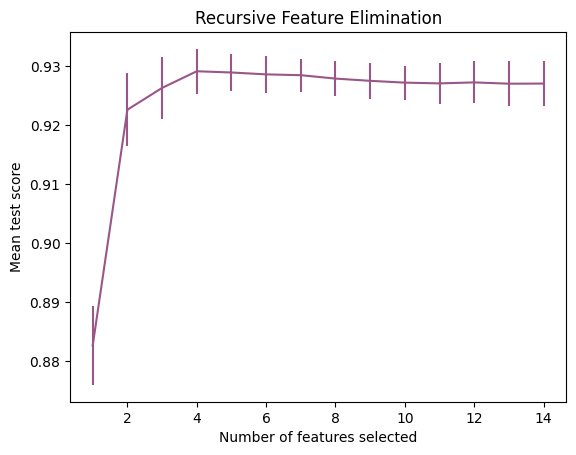

In [ ]:
# Calculate the number of different feature selections tested
n_scores = len(rfecv.cv_results_["mean_test_score"])

# Create a new figure for plotting
plt.figure()

# Set labels for the x and y axes
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")

# Plot the mean test scores with error bars
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
    color='#995687'  # Change the color to green
)

# Set the title for the plot
plt.title("Recursive Feature Elimination")

# Show the plot
plt.show()

In [ ]:
# Define a function to compute various scores for model evaluation
def get_scores(Y_pred, Y):
    # Calculate confusion matrix, classification report, ROC AUC, and accuracy
    conf_matrix = confusion_matrix(Y_pred, Y)
    class_report = classification_report(Y_pred, Y)
    auc = roc_auc_score(Y_pred, Y)
    acc = accuracy_score(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, class_report, auc, acc

# Define a function to print the computed scores
def print_scores(conf_matrix, class_report, auc, acc):
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

In [ ]:
# Select only the features that were chosen by RFECV
# X_train = X_train_filled_mice[:, rfecv.support_]
# X_test = X_test_filled_mice[:, rfecv.support_]

# Need to compare models with the same features

# Initialize and train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train_filled_mice, y_train)

# Make predictions on the test and training sets
y_pred_test = model.predict(X_test_filled_mice)
y_pred_train = model.predict(X_train_filled_mice)

# Calculate evaluation metrics and scores for the test and training sets
conf_matrix_test, class_report_test, auc_test, acc_test = get_scores(y_pred_test, y_test)
conf_matrix_train, class_report_train, auc_train, acc_train = get_scores(y_pred_train, y_train)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, class_report_train, auc_train, acc_train)

# Print scores and evaluation metrics for the test set
print('======== Test Set ==========')
print_scores(conf_matrix_test, class_report_test, auc_test, acc_test)

======== Training Set ==========
AUC :  0.8592543617284508
Accuracy :  0.8591428571428571
Confusion Matrix:
[[2960  561]
 [ 425 3054]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      3521
           1       0.84      0.88      0.86      3479

    accuracy                           0.86      7000
   macro avg       0.86      0.86      0.86      7000
weighted avg       0.86      0.86      0.86      7000

======== Test Set ==========
AUC :  0.8555649215602059
Accuracy :  0.8546666666666667
Confusion Matrix:
[[659 128]
 [ 90 623]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       787
           1       0.83      0.87      0.85       713

    accuracy                           0.85      1500
   macro avg       0.85      0.86      0.85      1500
weighted avg       0.86      0.85      0.85      1500



Random Forest

In [7]:
# define features and outcome
X = df.drop(['DIABETES'], axis=1)
y = df[['DIABETES']]

# split training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=1)

# Normalizing data
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# check class imbalance

print(f'The number of observations in the training set with diabetes is {sum(y_train == 1)[0]}')
print(f'The number of observations in the training set without diabetes is {sum(y_train == 0)[0]}')

# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_filled_mice = imputer.fit_transform(X_train)
X_val_filled_mice = imputer.transform(X_val)
X_test_filled_mice = imputer.transform(X_test)

The number of observations in the training set with diabetes is 3615
The number of observations in the training set without diabetes is 3385


In [9]:
# Define hyperparameters grid
param_grid = {'n_estimators': [100, 150, 200],
              'max_features': ['sqrt', 'log2'],
              'max_depth': [10, 20, 30],
              'min_samples_split': [10, 15, 20],
              'min_samples_leaf': [10, 15, 20] }

# Initialize Random Forest classifier
clf = RandomForestClassifier(oob_score=True, random_state=42)

# Use Grid Search to find the best hyperparameters
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_val_filled_mice, y_val)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [10, 15, 20],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [100, 150, 200]},
             verbose=2)

In [10]:
# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the OOB score of the best model
best_clf = grid_search.best_estimator_

print("OOB Score of Best Model:", best_clf.oob_score_)

# Storing and displaying the results of the grid search
results = pd.DataFrame(grid_search.cv_results_)
results[results['rank_test_score'] == 1]

Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100}
OOB Score of Best Model: 0.8566666666666667


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
72,0.403335,0.013284,0.011942,0.000912,20,sqrt,20,10,100,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
75,0.694111,0.058279,0.015640,0.006463,20,sqrt,20,15,100,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
78,0.437667,0.069637,0.013046,0.004180,20,sqrt,20,20,100,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
99,0.407680,0.014366,0.011768,0.001999,20,log2,20,10,100,"{'max_depth': 20, 'max_features': 'log2', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
102,0.396693,0.011568,0.010671,0.000411,20,log2,20,15,100,"{'max_depth': 20, 'max_features': 'log2', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
105,0.600014,0.105879,0.015077,0.005349,20,log2,20,20,100,"{'max_depth': 20, 'max_features': 'log2', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
126,0.586260,0.126769,0.015027,0.003293,30,sqrt,20,10,100,"{'max_depth': 30, 'max_features': 'sqrt', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
129,0.402083,0.012578,0.011128,0.000875,30,sqrt,20,15,100,"{'max_depth': 30, 'max_features': 'sqrt', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
132,0.397487,0.015863,0.011327,0.001107,30,sqrt,20,20,100,"{'max_depth': 30, 'max_features': 'sqrt', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
153,0.400399,0.011718,0.011191,0.000784,30,log2,20,10,100,"{'max_depth': 30, 'max_features': 'log2', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1


In [11]:
# Updating the model's parameters with the best ones found from GridSearchCV
model = clf.set_params(**grid_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(X_train_filled_mice, y_train)

# Predicting on the training dataset and computing the accuracy
y_pred_train = model.predict(X_train_filled_mice)
print(accuracy_score(y_train, y_pred_train))

# Predicting on the test dataset and computing the accuracy
y_pred_test = model.predict(X_test_filled_mice)
print(accuracy_score(y_test, y_pred_test))

print(classification_report(y_pred_train, y_train))
print(classification_report(y_pred_test, y_test))

0.8778571428571429
0.8553333333333333
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      3502
           1       0.87      0.89      0.88      3498

    accuracy                           0.88      7000
   macro avg       0.88      0.88      0.88      7000
weighted avg       0.88      0.88      0.88      7000

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       772
           1       0.84      0.87      0.85       728

    accuracy                           0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500



XGBoost

In [13]:
# Initializing the Gradient Boosting Classifier with specified parameters
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Defining the hyperparameters to be tuned using GridSearchCV
param_dist = {
    "n_estimators" : [100, 150, 200],
    "max_depth" : [1, 3, 5],
    "min_samples_leaf" : [10, 15, 20],
    "learning_rate" : [0.01, 0.05, 0.1]
}

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
skf = StratifiedKFold(n_splits=10)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(model, param_grid=param_dist, cv=skf)

# Fitting the GridSearchCV on the training data
# GradientBoostingClassifier does not accept missing values encoded as NaN natively.
# For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively.
random_search.fit(X_val_filled_mice, y_val)

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
44,0.696373,0.104947,0.001907,0.000235,0.05,3,20,200,"{'learning_rate': 0.05, 'max_depth': 3, 'min_s...",0.86,...,0.853333,0.886667,0.893333,0.873333,0.82,0.92,0.833333,0.862,0.041958,1


In [14]:
random_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'min_samples_leaf': 20,
 'n_estimators': 200}

In [15]:
# Updating the model's parameters with the best ones found from GridSearchCV
model = model.set_params(**random_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(X_train_filled_mice, y_train)

# Predicting on the training dataset and computing the accuracy
y_pred_train = model.predict(X_train_filled_mice)
print(accuracy_score(y_train, y_pred_train))

# Predicting on the test dataset and computing the accuracy
y_pred_test = model.predict(X_test_filled_mice)
print(accuracy_score(y_test, y_pred_test))

print(classification_report(y_pred_train, y_train))
print(classification_report(y_pred_test, y_test))

0.8748571428571429
0.8586666666666667
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      3545
           1       0.86      0.90      0.88      3455

    accuracy                           0.87      7000
   macro avg       0.88      0.88      0.87      7000
weighted avg       0.88      0.87      0.87      7000

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       775
           1       0.84      0.87      0.86       725

    accuracy                           0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500



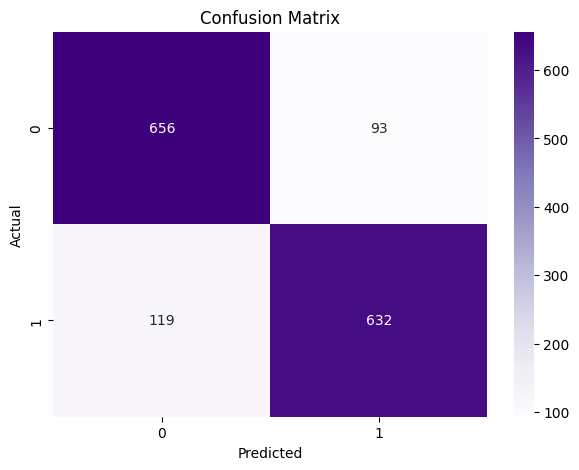

In [16]:
# Get unique classes
classes = df['DIABETES'].unique()

# Plotting the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_test),
            cmap='Purples', annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Depression vs no depression with XGBoost

In [17]:
# separate the data set into two sets
dep = df[df['Depression'] == 1]
no_dep = df[df['Depression'] == 0]

# check if all observations are covered
print(f'The number of observations with depression in this data set is {len(dep)}')
print(f'The number of observations without depression in this data set is {len(no_dep)}')

The number of observations with depression in this data set is 2122
The number of observations without depression in this data set is 7878


XGBoost for people with depression

In [18]:
# run XGBoost on people with depression first

# define features and outcome
X = dep.drop(['DIABETES'], axis=1)
y = dep[['DIABETES']]

# split training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=1)

# Normalizing data
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# check class imbalance

print(f'The number of observations in the training set with diabetes is {sum(y_train == 1)[0]}')
print(f'The number of observations in the training set without diabetes is {sum(y_train == 0)[0]}')

# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_filled_mice = imputer.fit_transform(X_train)
X_val_filled_mice = imputer.transform(X_val)
X_test_filled_mice = imputer.transform(X_test)

# Initializing the Gradient Boosting Classifier with specified parameters
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Defining the hyperparameters to be tuned using GridSearchCV
param_dist = {
    "n_estimators" : [100, 150, 200],
    "max_depth" : [1, 3, 5],
    "min_samples_leaf" : [10, 15, 20],
    "learning_rate" : [0.01, 0.05, 0.1]
}

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
skf = StratifiedKFold(n_splits=10)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(model, param_grid=param_dist, cv=skf)

# Fitting the GridSearchCV on the training data
random_search.fit(X_val_filled_mice, y_val)

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

The number of observations in the training set with diabetes is 727
The number of observations in the training set without diabetes is 757


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.118154,0.019306,0.001271,0.000084,0.1,1,25,100,"{'learning_rate': 0.1, 'max_depth': 1, 'min_sa...",0.875,...,0.8125,0.875,0.84375,0.84375,0.84375,0.84375,0.870968,0.843347,0.023711,1


0.8598382749326146
0.8808777429467085
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       841
           1       0.80      0.90      0.85       643

    accuracy                           0.86      1484
   macro avg       0.86      0.86      0.86      1484
weighted avg       0.87      0.86      0.86      1484

              precision    recall  f1-score   support

           0       0.94      0.85      0.90       191
           1       0.81      0.92      0.86       128

    accuracy                           0.88       319
   macro avg       0.88      0.89      0.88       319
weighted avg       0.89      0.88      0.88       319



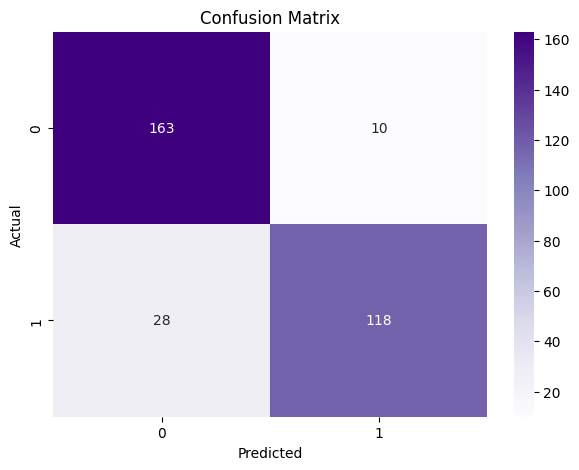

In [19]:
# Updating the model's parameters with the best ones found from GridSearchCV
model = model.set_params(**random_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(X_train_filled_mice, y_train)

# Predicting on the training dataset and computing the accuracy
y_pred_train = model.predict(X_train_filled_mice)
print(accuracy_score(y_train, y_pred_train))

# Predicting on the test dataset and computing the accuracy
y_pred_test = model.predict(X_test_filled_mice)
print(accuracy_score(y_test, y_pred_test))

print(classification_report(y_pred_train, y_train))
print(classification_report(y_pred_test, y_test))

# Get unique classes
classes = dep['DIABETES'].unique()

# Plotting the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_test),
            cmap='Purples', annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

XGBoost for people without depression

In [ ]:
# define features and outcome
X = no_dep.drop(['DIABETES'], axis=1)
y = no_dep[['DIABETES']]

# split training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=1)

# Normalizing data
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# check class imbalance

print(f'The number of observations in the training set with diabetes is {sum(y_train == 1)[0]}')
print(f'The number of observations in the training set without diabetes is {sum(y_train == 0)[0]}')

# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_filled_mice = imputer.fit_transform(X_train)
X_val_filled_mice = imputer.transform(X_val)
X_test_filled_mice = imputer.transform(X_test)

# Initializing the Gradient Boosting Classifier with specified parameters
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Defining the hyperparameters to be tuned using GridSearchCV
param_dist = {
    "n_estimators" : [100, 150, 200],
    "max_depth" : [1, 3, 5],
    "min_samples_leaf" : [10, 15, 20],
    "learning_rate" : [0.01, 0.05, 0.1]
}

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
skf = StratifiedKFold(n_splits=10)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(model, param_grid=param_dist, cv=skf)

# Fitting the GridSearchCV on the training data
random_search.fit(X_val_filled_mice, y_val)

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

The number of observations in the training set with diabetes is 2912
The number of observations in the training set without diabetes is 2602


In [ ]:
# Updating the model's parameters with the best ones found from GridSearchCV
model = model.set_params(**random_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(X_train_filled_mice, y_train)

# Predicting on the training dataset and computing the accuracy
y_pred_train = model.predict(X_train_filled_mice)
print(accuracy_score(y_train, y_pred_train))

# Predicting on the test dataset and computing the accuracy
y_pred_test = model.predict(X_test_filled_mice)
print(accuracy_score(y_test, y_pred_test))

print(classification_report(y_pred_train, y_train))
print(classification_report(y_pred_test, y_test))

# Get unique classes
classes = dep['DIABETES'].unique()

# Plotting the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_test),
            cmap='Purples', annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()